## This code takes the college basketball data and models it using logistic regression

In [1]:
#import packages

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pprint import pprint
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE, RFECV
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import StratifiedKFold
from hyperopt import fmin, tpe, anneal, hp, STATUS_OK, Trials, space_eval
import hyperopt.pyll.stochastic
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [2]:
#creating functions to evaluate model fit

def get_preds(threshold, probabilities):
    return [1 if prob > threshold else 0 for prob in probabilities]


def evaluate_classification(model, test_features, test_labels, extra = False):
    
    predictions = model.predict(test_features)
    
    accuracy = sum(predictions == test_labels)/len(test_labels)
    
    class_rep = classification_report(test_labels, predictions, digits = 4)
    
    cf_matrix = confusion_matrix(test_labels, predictions)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues', xticklabels = ['Predicted Loss', 'Predicted Win'],
               yticklabels = ['Actual Loss', 'Actual Win'])
    

    print('Model Performance\n')
    print('Accuracy = ',(accuracy),'\n')
    print('Classification Report\n')
    print(class_rep)
    plt.show()
    
    
    
    if extra == True:
        
        probas = model.predict_proba(test_features)[:, 1]
        
        print('Area Under the Curve =', roc_auc_score(test_labels, probas))
        
        
        
        roc_values = []
        for thresh in np.linspace(0, 1, 100):
            preds = get_preds(thresh, probas)
            tn, fp, fn, tp = confusion_matrix(test_labels, preds).ravel()
            tpr = tp/(tp+fn)
            fpr = fp/(fp+tn)
            roc_values.append([tpr, fpr])
            
        tpr_values, fpr_values = zip(*roc_values)
        
        fig, ax = plt.subplots(figsize=(10,7))
        ax.plot(fpr_values, tpr_values)
        ax.plot(np.linspace(0, 1, 100),
        np.linspace(0, 1, 100),
        label='baseline',
        linestyle='--')
        plt.title('Receiver Operating Characteristic Curve', fontsize=18)
        plt.ylabel('TPR', fontsize=16)
        plt.xlabel('FPR', fontsize=16)
        plt.legend(fontsize=12)
        
        plt.show()
        
def compare_classification(model1, model2, test_features1, test_features2, test_labels):
    
    predictions1 = model1.predict(test_features1)
    predictions2 = model2.predict(test_features2)
    
    probas1 = model1.predict_proba(test_features1)[:, 1]
    probas2 = model2.predict_proba(test_features2)[:, 1]
    
    auc1 = roc_auc_score(test_labels, probas1)
    auc2 = roc_auc_score(test_labels, probas2)
    
    accuracy1 = sum(predictions1 == test_labels)/len(test_labels)
    accuracy2 = sum(predictions2 == test_labels)/len(test_labels)
    
    class_rep1 = classification_report(test_labels, predictions1, digits = 4)
    class_rep2 = classification_report(test_labels, predictions2, digits = 4)
    
    acc_diff = accuracy2 - accuracy1
    auc_diff = auc2 - auc1
    
    
    if acc_diff > 0:
        result_acc = 'Accuracy: Model 2 better'
    elif acc_diff == 0:
        result_acc = "Accuracy: Models perform the same"
    else:
        result_acc = "Accuracy: Model 1 better"
        
    if auc_diff > 0:
        result_auc = 'AUC: Model 2 better'
    elif auc_diff == 0:
        result_auc = "AUC: Models perform the same"
    else:
        result_auc = "AUC: Model 1 better"
    
    print('           Model 1 Performance   ', 'Model 2 Performance', '  Difference (Model2 - Model1)')
    print('Accuracy: ',(accuracy1),"   ",(accuracy2),"   ",(acc_diff),"    ",result_acc)
    print('AUC: ',(auc1),"   ",(auc2),"   ",(auc_diff),"    ",result_auc)
    
    
def evaluate_test(models, test_features, test_outcomes, sort_var = 'acc'):
    
    full_result = pd.DataFrame()
    
    for x in range(len(models)):
          
        predictions = models[x].predict(test_features[x])
        probs = models[x].predict_proba(test_features[x])[:, 1]
        
        auc = roc_auc_score(test_outcomes, probs)
        accuracy = sum(predictions == test_outcomes)/len(test_outcomes)
        
        current_result = pd.DataFrame({'model_name': [name_of_object(models[x])],
                                       'model':[models[x]],
                                       'data_name': [name_of_object(test_features[x])],
                                       'data':[test_features[x].to_dict()],
                                       'acc':[accuracy], 'auc':[auc]})
        
        full_result = full_result.append(current_result, ignore_index = True)
        
    full_result.reset_index(drop=True, inplace = True)
        
    full_result['acc_rank'] = full_result['acc'].rank(ascending = False)
    full_result['auc_rank'] = full_result['auc'].rank(ascending = False)
    
    #if sort_var == 'acc':
        
    full_result.sort_values(by = ['acc_rank','auc_rank'], inplace=True)
        
    #elif sort_var == 'auc': 
    
    #    full_result.sort_values(by = ['auc_rank'], inplace=True)
        
    #else:
    
    #    full_result = full_result
        
    return(full_result)

def name_of_object(arg):
    # check __name__ attribute (functions)
    try:
        return arg.__name__
    except AttributeError:
        pass

    for name, value in globals().items():
        if value is arg and not name.startswith('_'):
            return name

## Importing data and conducting minor cleaning including converting the outcome varible to 0/1, then setting up training and testing sets

In [3]:
#import data
full_data = pd.read_csv("College Data/Weighted Mean Converted Data.csv")

In [4]:
#inspect data columns
full_data.columns

Index(['Date', 'G', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'Location', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%', 'FT/FGA',
       'DRB%', 'AST%', 'TS%', '3PAr', 'DRB', 'POSS', 'OffRt', 'DefRt', 'FG.1',
       'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1', 'FTA.1', 'FT%.1',
       'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1', 'PF.1', 'eFG.1',
       'TOV%.1', 'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1', 'TS%.1', '3PAr.1',
       'DRB.1', 'POSS.1', 'OffRt.1', 'DefRt.1'],
      dtype='object')

In [5]:
full_data.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,Location,FG,FGA,...,ORB%.1,FT/FGA.1,DRB%.1,AST%.1,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1
0,2022-11-11,2,texas-am,L,77,58,abilene-christian,A,23.000000,57.000000,...,0.264706,0.174603,0.813953,0.656250,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503
1,2022-11-21,4,wright-state,L,77,61,abilene-christian,N,31.000000,60.833333,...,0.291657,0.214480,0.806891,0.425512,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734
2,2022-11-22,5,weber-state,L,77,67,abilene-christian,N,28.600000,59.700000,...,0.139543,0.301987,0.795111,0.436316,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632
3,2022-11-23,6,california-riverside,L,76,65,abilene-christian,N,27.733333,57.466667,...,0.249515,0.118953,0.856104,0.486961,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350
4,2022-11-27,7,northern-arizona,W,82,92,abilene-christian,A,26.095238,58.190476,...,0.281522,0.178352,0.713698,0.581618,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669


In [6]:
#converting Location variable with one-hot encoding (dummy coding)

full_data_adv = pd.get_dummies(full_data, columns = ['Location'])

full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,AST%.1,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N
0,2022-11-11,2,texas-am,L,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.656250,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0
1,2022-11-21,4,wright-state,L,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.425512,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1
2,2022-11-22,5,weber-state,L,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.436316,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1
3,2022-11-23,6,california-riverside,L,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.486961,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1
4,2022-11-27,7,northern-arizona,W,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.581618,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0


In [7]:
full_data_adv.columns

Index(['Date', 'G', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%', 'FT/FGA', 'DRB%', 'AST%',
       'TS%', '3PAr', 'DRB', 'POSS', 'OffRt', 'DefRt', 'FG.1', 'FGA.1',
       'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1', 'FTA.1', 'FT%.1', 'ORB.1',
       'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1', 'PF.1', 'eFG.1', 'TOV%.1',
       'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1', 'TS%.1', '3PAr.1', 'DRB.1',
       'POSS.1', 'OffRt.1', 'DefRt.1', 'Location_A', 'Location_H',
       'Location_N'],
      dtype='object')

In [8]:
#creating overtime variable

full_data_adv['OT'] = full_data_adv['W/L'].str.split().str[2].str[0:2]
full_data_adv['OT'].fillna(0, inplace = True)
full_data_adv['OT'].replace('OT', 1, inplace = True)

In [9]:
#examining outcome variable values
full_data_adv['W/L'].unique()

array(['L', 'W', 'L\xa0(2 OT)', 'L\xa0(1 OT)', 'W\xa0(1 OT)',
       'W\xa0(4 OT)', 'W\xa0(2 OT)', 'W\xa0(3 OT)', 'L\xa0(3 OT)',
       'L\xa0(4 OT)'], dtype=object)

In [10]:
#removing extra text in win loss variable
full_data_adv['W/L'] = full_data_adv['W/L'].str.split().str[0]
full_data_adv['W/L'].unique()

array(['L', 'W'], dtype=object)

In [11]:
#Converting outcome variable from string to numeric
full_data_adv.replace({"W/L": {"W":1, "L":0}}, inplace = True)

In [12]:
#looking at cleaned data
full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N,OT
0,2022-11-11,2,texas-am,0,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0,0
1,2022-11-21,4,wright-state,0,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1,0
2,2022-11-22,5,weber-state,0,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1,0
3,2022-11-23,6,california-riverside,0,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1,0
4,2022-11-27,7,northern-arizona,1,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0,0


In [13]:
#examining number of rows and columns of cleaned data
full_data_adv.shape

(10693, 67)

In [14]:
#examining all variable types
pd.options.display.max_rows = 70
print(full_data_adv.dtypes)
pd.options.display.max_rows = 10

Date           object
G               int64
Opp            object
W/L             int64
Opp.1           int64
Tm              int64
Team           object
FG            float64
FGA           float64
FG%           float64
3P            float64
3PA           float64
3P%           float64
FT            float64
FTA           float64
FT%           float64
ORB           float64
TRB           float64
AST           float64
STL           float64
BLK           float64
TOV           float64
PF            float64
eFG           float64
TOV%          float64
ORB%          float64
FT/FGA        float64
DRB%          float64
AST%          float64
TS%           float64
3PAr          float64
DRB           float64
POSS          float64
OffRt         float64
DefRt         float64
FG.1          float64
FGA.1         float64
FG%.1         float64
3P.1          float64
3PA.1         float64
3P%.1         float64
FT.1          float64
FTA.1         float64
FT%.1         float64
ORB.1         float64
TRB.1     

In [15]:
#droping any duplicate rows
full_data_adv.dropna().drop_duplicates()
full_data_adv.shape

(10693, 67)

In [16]:
#columns that will not be used as features



fields_to_drop = ['G', 'Date', 'Opp', 'W/L', 'Opp.1', 'Tm', 'Team', 'OT']

#fields_to_keep = []



In [17]:
full_data_adv.head()

,Date,G,Opp,W/L,Opp.1,Tm,Team,FG,FGA,FG%,...,TS%.1,3PAr.1,DRB.1,POSS.1,OffRt.1,DefRt.1,Location_A,Location_H,Location_N,OT
0,2022-11-11,2,texas-am,0,77,58,abilene-christian,23.000000,57.000000,0.404000,...,0.613367,0.412698,35.000000,75.920000,114.594310,71.127503,1,0,0,0
1,2022-11-21,4,wright-state,0,77,61,abilene-christian,31.000000,60.833333,0.497167,...,0.633018,0.185174,27.700000,75.756000,117.233591,89.383734,0,0,1,0
2,2022-11-22,5,weber-state,0,77,67,abilene-christian,28.600000,59.700000,0.470700,...,0.530863,0.405271,23.300000,66.932000,94.437727,107.999632,0,0,1,0
3,2022-11-23,6,california-riverside,0,76,65,abilene-christian,27.733333,57.466667,0.477467,...,0.566101,0.417359,28.380952,70.076190,107.410494,89.856350,0,0,1,0
4,2022-11-27,7,northern-arizona,1,82,92,abilene-christian,26.095238,58.190476,0.445905,...,0.511688,0.412427,21.535714,72.134286,97.167696,98.975669,1,0,0,0


In [18]:
#creating feature data and examining number of rows and columns

X = full_data_adv.drop(columns = fields_to_drop)

print(X.shape)
X.columns

(10693, 59)


Index(['FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'eFG', 'TOV%', 'ORB%',
       'FT/FGA', 'DRB%', 'AST%', 'TS%', '3PAr', 'DRB', 'POSS', 'OffRt',
       'DefRt', 'FG.1', 'FGA.1', 'FG%.1', '3P.1', '3PA.1', '3P%.1', 'FT.1',
       'FTA.1', 'FT%.1', 'ORB.1', 'TRB.1', 'AST.1', 'STL.1', 'BLK.1', 'TOV.1',
       'PF.1', 'eFG.1', 'TOV%.1', 'ORB%.1', 'FT/FGA.1', 'DRB%.1', 'AST%.1',
       'TS%.1', '3PAr.1', 'DRB.1', 'POSS.1', 'OffRt.1', 'DefRt.1',
       'Location_A', 'Location_H', 'Location_N'],
      dtype='object')

In [19]:
#Create outcome data

y = full_data_adv['W/L'].values

y.shape

(10693,)

In [20]:
#Create training, validation, and test data

train_ratio = 0.60
validation_ratio = 0.25
test_ratio = 0.15


# train is now 70% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size= test_ratio,
                                                    stratify = y,
                                                    random_state = 17)

 #test is now 10% of the initial data set
 #validation is now 20% of the initial data set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=validation_ratio/(train_ratio + validation_ratio),
                                                 stratify = y_train,
                                                 random_state = 17) 

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train.shape[0]/X.shape[0], X_val.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0])
print(y_train.sum()/len(y_train), y_val.sum()/len(y_val), y_test.sum()/len(y_test))

(6415, 59) (2674, 59) (1604, 59)
0.5999251847002712 0.25007013934349576 0.15000467595623304
0.5016367887763056 0.5014958863126402 0.5018703241895262


In [21]:
#Standardizing the predictor variables into Z scores

#take categorical variables and one-hot encode
dummy_train = X_train[['Location_A','Location_H','Location_N']]
dummy_train.reset_index(drop = True, inplace = True)
dummy_val = X_val[['Location_A','Location_H','Location_N']]
dummy_val.reset_index(drop = True, inplace = True)
dummy_test = X_test[['Location_A','Location_H','Location_N']]
dummy_test.reset_index(drop = True, inplace = True)

#create subset of data with just continuous variables
X_train1 = X_train.drop(['Location_A','Location_H','Location_N'], axis = 1)
X_val1 =  X_val.drop(['Location_A','Location_H','Location_N'], axis = 1)
X_test1 =  X_test.drop(['Location_A','Location_H','Location_N'], axis = 1)

#standardize continuous variables
scaler = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train1))
X_train_std.columns = X_train1.columns
X_val_std = pd.DataFrame(scaler.transform(X_val1))
X_val_std.columns = X_val1.columns
X_test_std = pd.DataFrame(scaler.transform(X_test1))
X_test_std.columns = X_test1.columns

#combine continuous and categorical variables
X_train_d = pd.concat([X_train_std, dummy_train], axis = 1)
X_val_d = pd.concat([X_val_std, dummy_val], axis = 1)
X_test_d = pd.concat([X_test_std, dummy_test], axis = 1)

#drop on category for logistic regression modelling
X_train_full = X_train_d.drop(['Location_N'], axis = 1)
X_val_full = X_val_d.drop(['Location_N'], axis = 1)
X_test_full = X_test_d.drop(['Location_N'], axis = 1)

## Running a basic logistic regression model with no penalty term and examining the results

In [22]:
#create basic logistic regression object
logreg = LogisticRegression(random_state = 0, max_iter = 1000, penalty = 'none')

In [23]:
#fit basic logistic regression model to training data
logreg.fit(X_train_full,y_train)

LogisticRegression(max_iter=1000, penalty='none', random_state=0)

Model Performance

Accuracy =  0.668661181750187 

Classification Report

              precision    recall  f1-score   support

           0     0.6705    0.6594    0.6649      1333
           1     0.6669    0.6779    0.6723      1341

    accuracy                         0.6687      2674
   macro avg     0.6687    0.6686    0.6686      2674
weighted avg     0.6687    0.6687    0.6686      2674



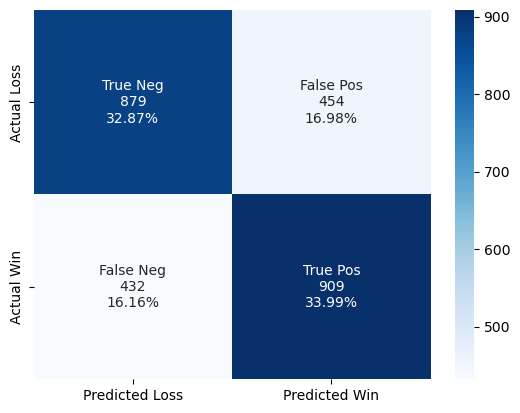

Area Under the Curve = 0.7276545087054762


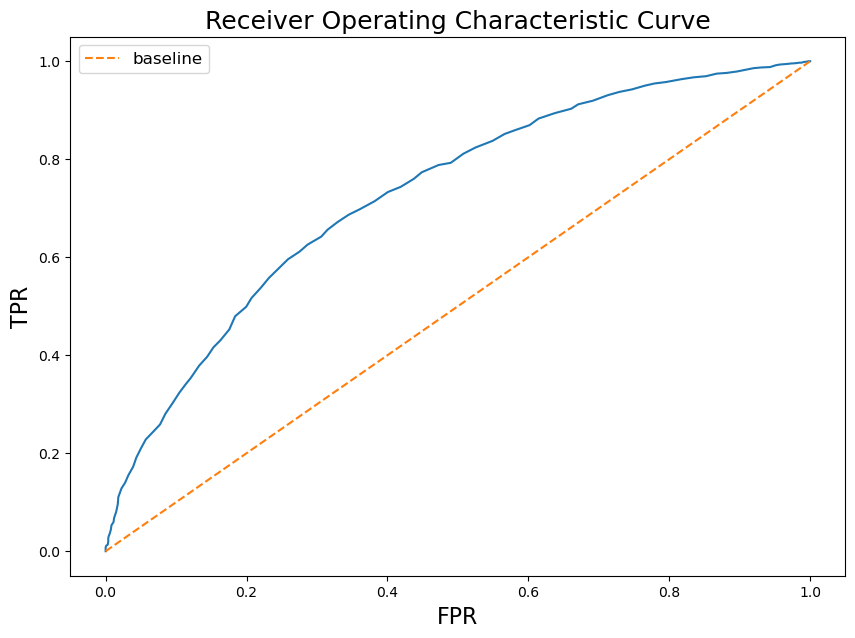

In [24]:
#evaluate trained logistic regression model on test data

evaluate_classification(logreg, X_val_full, y_val, extra = True)

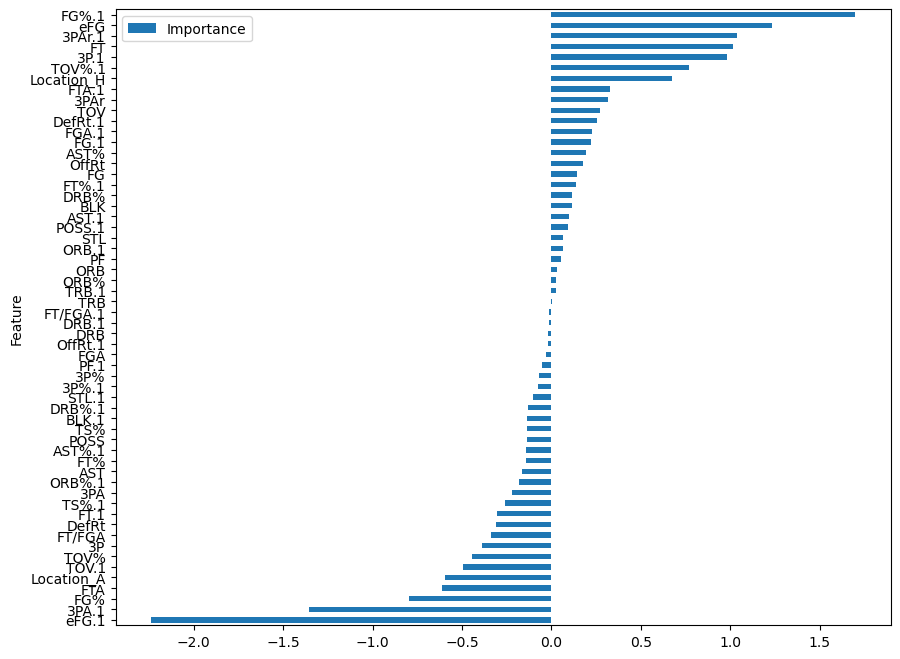

In [82]:
#examining variable importance
coefficients = logreg.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train_full.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

In [26]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
44       eFG.1   -2.240720
32       3PA.1   -1.355055
2          FG%   -0.798085
7          FTA   -0.614888
56  Location_A   -0.594885
42       TOV.1   -0.491932
17        TOV%   -0.442152
3           3P   -0.389055
19      FT/FGA   -0.340037
27       DefRt   -0.312251
34        FT.1   -0.305409
50       TS%.1   -0.261584
4          3PA   -0.220034
46      ORB%.1   -0.181625
11         AST   -0.165591
8          FT%   -0.144970
49      AST%.1   -0.141610
25        POSS   -0.138364
22         TS%   -0.135048
41       BLK.1   -0.134828
48      DRB%.1   -0.128560
40       STL.1   -0.103619
33       3P%.1   -0.078039
5          3P%   -0.067761
43        PF.1   -0.053984
1          FGA   -0.030965
54     OffRt.1   -0.021363
24         DRB   -0.016818
52       DRB.1   -0.015643
47    FT/FGA.1   -0.015237
10         TRB    0.005064
38       TRB.1    0.025534
18        ORB%    0.026043
9          ORB    0.031453
15          PF    0.052500
37       ORB.1    0.066663
1

## Note: Many of out variables are not that important, so we can probably remove some of them later, but first lets optimize the model for this full set of variables

## Now lets use hyperopt to optimize the Logistic Regression and add the elasticnet penalty

In [27]:
#create function to optimize

def hyperopt_train_test(params):

    model = LogisticRegression(**params)
    model.fit(X_train_full, y_train)
    y_pred = model.predict(X_val_full)
    return accuracy_score(y_val, y_pred)


In [28]:
#assign values for hyperopt to explore as it searches for optimal parameters
space = {
    'penalty': hp.choice('penalty', ['elasticnet']),
    'solver': hp.choice('solver', ['saga']),
    'l1_ratio': hp.uniform('l1_ratio', 0,1),
    'C': hp.uniform('C', 0,0.1),
    'max_iter': 10000,
    'random_state': 0,
}


In [29]:
best = 0
count = 0
def f(params):
    global best, count
    count += 1
    
    model = LogisticRegression(**params)
    model.fit(X_train_full, y_train)
    
    y_pred_train = model.predict(X_train_full)
    y_pred_val = model.predict(X_val_full)
    
    acc = accuracy_score(y_val, y_pred_val)
    
    if acc > best:
        best = acc
        print('new best:', best, params, count)
        
    return {'loss': -acc,
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'train_loss': -accuracy_score(y_train, y_pred_train)}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=1000, trials=trials,
            rstate = np.random.default_rng(0))
print('best:')
print(best)

new best:                                                                       
0.6645474943904264                                                              
{'C': 0.018933342815492693, 'l1_ratio': 0.6822636207462247, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 0, 'solver': 'saga'}
1                                                                               
new best:                                                                       
0.6649214659685864                                                              
{'C': 0.027574444840384207, 'l1_ratio': 0.8271158422569497, 'max_iter': 10000, 'penalty': 'elasticnet', 'random_state': 0, 'solver': 'saga'}
2                                                                               
new best:                                                                       
0.6716529543754675                                                              
{'C': 0.07028021307836788, 'l1_ratio': 0.4421542674710245, 'max_iter':

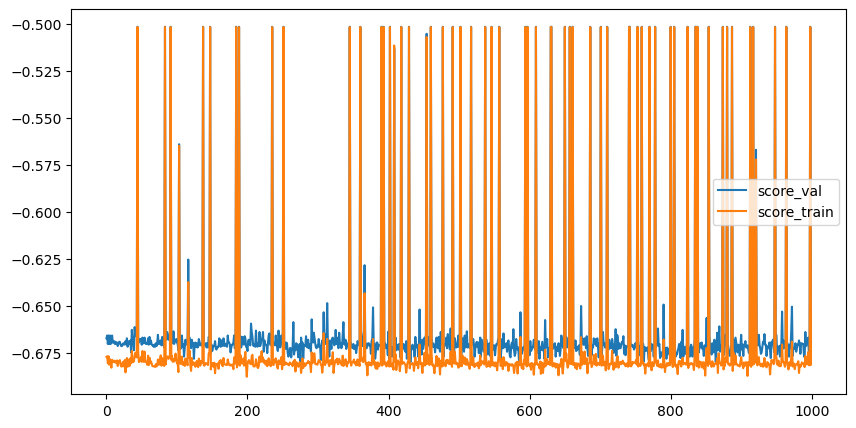

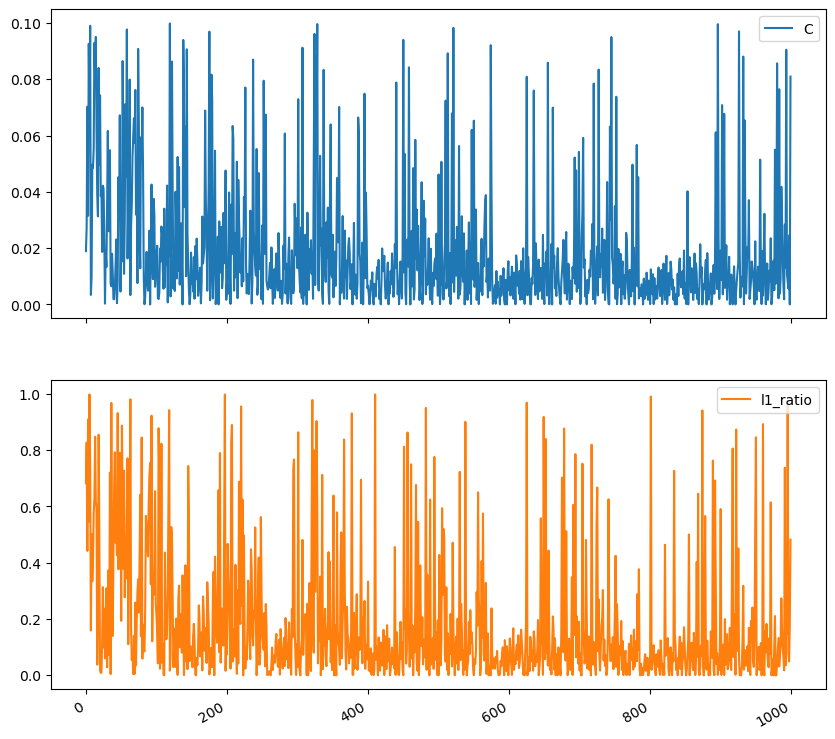

In [86]:
#examine loss and C parameter graphs over all iterations of hyperopt
results=np.array([[x['result']['loss']] for x in trials.trials])

results2=np.array([x['train_loss'] for x in trials.results])

results_loss=pd.DataFrame(results,
                           columns=['score_val'])

results_loss['score_train'] = results2

results_loss.plot(subplots=False,figsize=(10,5))



results3=np.array([[x['misc']['vals']['C'][0],
                   x['misc']['vals']['l1_ratio'][0]] for x in trials.trials])

results_df1=pd.DataFrame(results3,
                           columns=['C', 'l1_ratio'])

results_df1.plot(subplots=True,figsize=(10, 10))


plt.show()


In [31]:
#examine best parameters
best1 = space_eval(space, best)
best1

{'C': 0.0036075505610419084,
 'l1_ratio': 0.0006835728510696,
 'max_iter': 10000,
 'penalty': 'elasticnet',
 'random_state': 0,
 'solver': 'saga'}

In [32]:
#train model using best parameters from search
hyp_logreg = LogisticRegression(C = best1['C'],
                  max_iter = best1['max_iter'],
                  penalty = best1['penalty'],
                  solver = best1['solver'],
                                l1_ratio = best1['l1_ratio'],
                  random_state =  best1['random_state'])

hyp_logreg.fit(X_train_full, y_train)

LogisticRegression(C=0.0036075505610419084, l1_ratio=0.0006835728510696,
                   max_iter=10000, penalty='elasticnet', random_state=0,
                   solver='saga')

In [33]:
#examine accuracy on training data
y_pred = hyp_logreg.predict(X_train_full)
print('Training Data Classification Report for estimator: ',
      str(hyp_logreg).split('(')[0])
print('\n', classification_report(y_train, y_pred))

Training Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.69      0.68      0.68      3197
           1       0.68      0.69      0.69      3218

    accuracy                           0.68      6415
   macro avg       0.68      0.68      0.68      6415
weighted avg       0.68      0.68      0.68      6415



In [34]:
#examine accuracy on test data
y_pred = hyp_logreg.predict(X_val_full)

# TEST -- classification report and store predictions/ probabilities
print('Test Data Classification Report for estimator: ',
      str(hyp_logreg).split('(')[0])
print('\n', classification_report(y_val, y_pred))

Test Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.68      0.68      1333
           1       0.68      0.68      0.68      1341

    accuracy                           0.68      2674
   macro avg       0.68      0.68      0.68      2674
weighted avg       0.68      0.68      0.68      2674



Model Performance

Accuracy =  0.680628272251309 

Classification Report

              precision    recall  f1-score   support

           0     0.6805    0.6774    0.6789      1333
           1     0.6808    0.6838    0.6823      1341

    accuracy                         0.6806      2674
   macro avg     0.6806    0.6806    0.6806      2674
weighted avg     0.6806    0.6806    0.6806      2674



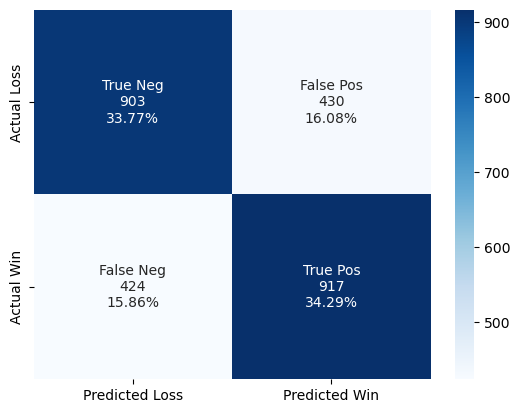

Area Under the Curve = 0.7343043814644936


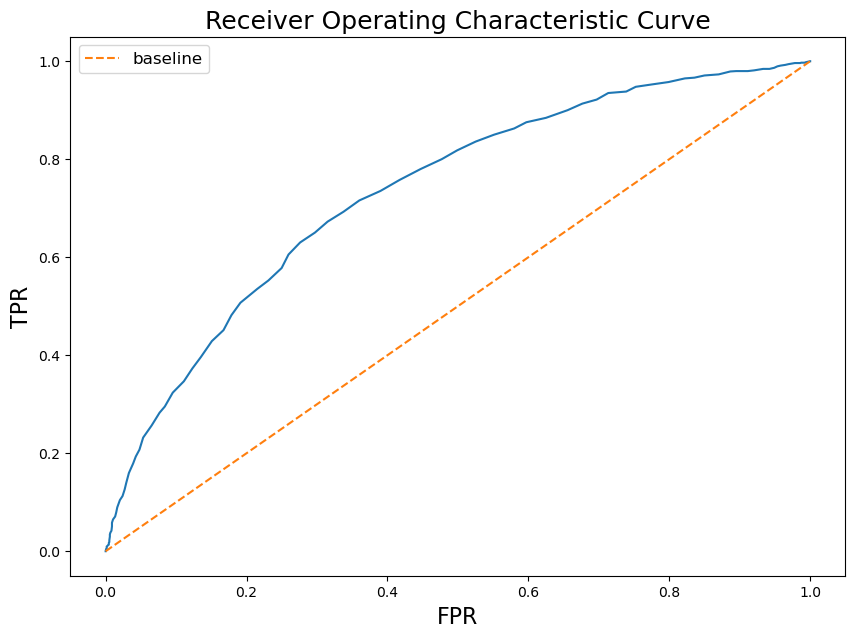

In [35]:
#further investigate accuracy on test data
evaluate_classification(hyp_logreg, X_val_full, y_val, extra = True)

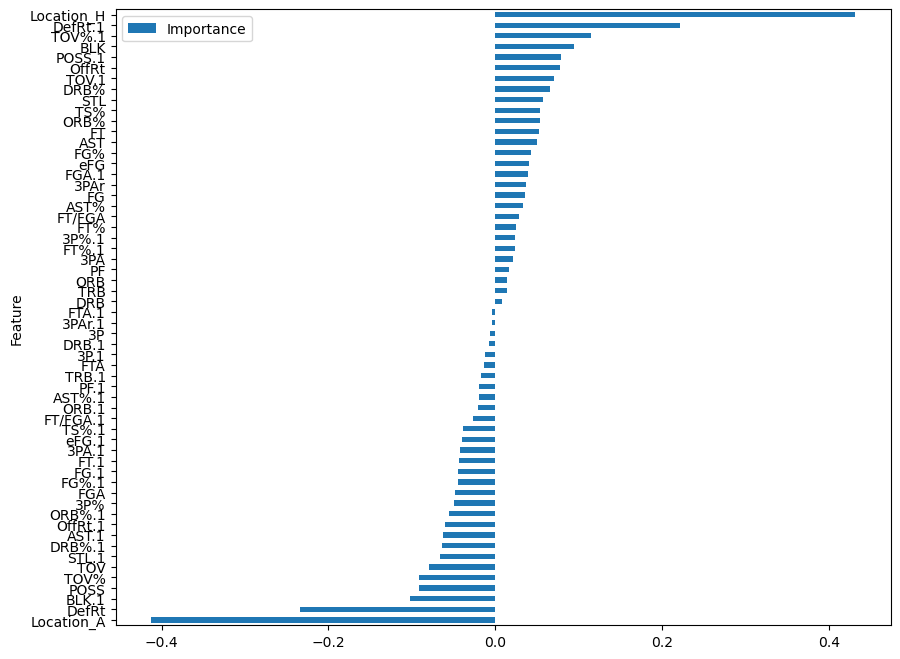

In [87]:
#examining variable importance
coefficients = hyp_logreg.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train_full.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

In [37]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
56  Location_A   -0.413081
27       DefRt   -0.234673
41       BLK.1   -0.101833
25        POSS   -0.091978
17        TOV%   -0.091189
14         TOV   -0.079546
40       STL.1   -0.066194
48      DRB%.1   -0.064184
39       AST.1   -0.062906
54     OffRt.1   -0.060196
46      ORB%.1   -0.055721
5          3P%   -0.049612
1          FGA   -0.048541
30       FG%.1   -0.045201
28        FG.1   -0.044275
34        FT.1   -0.043892
32       3PA.1   -0.041866
44       eFG.1   -0.040200
50       TS%.1   -0.039036
47    FT/FGA.1   -0.026999
37       ORB.1   -0.020950
49      AST%.1   -0.020108
43        PF.1   -0.020031
38       TRB.1   -0.016774
7          FTA   -0.012999
31        3P.1   -0.012097
52       DRB.1   -0.006981
3           3P   -0.005780
51      3PAr.1   -0.004308
35       FTA.1   -0.003909
24         DRB    0.008294
10         TRB    0.014025
9          ORB    0.014574
15          PF    0.016468
4          3PA    0.021040
36       FT%.1    0.023647
3

In [38]:
#compare original logistic regression to optimized
compare_classification(logreg, hyp_logreg, X_val_full, X_val_full, y_val)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.668661181750187     0.680628272251309     0.01196709050112199      Accuracy: Model 2 better
AUC:  0.7276545087054762     0.7343043814644936     0.006649872759017406      AUC: Model 2 better


## The optimized model performs better than the base model and we see that the variable importance also shows there are only a few important variables

## It may be the case that some variables are not that important, as a result we can try using Recrusive Feature Selection to narrow down our variable list

In [39]:
#creating a base Logistic Regression model object
# then creating a recursive feature elimination object
# then fitting to the training data
LR_estimator = LogisticRegression(random_state=0, max_iter = 5000)
LR_select = RFECV(LR_estimator, step=1, cv=5, n_jobs = -1)
LR_selector = LR_select.fit(X_train_full, y_train)


In [40]:
#examining how many of the original features were retained
(LR_selector.support_).sum()

40

In [41]:
#examining which features were retained
X_train_full.columns[LR_selector.support_]

Index(['FG', 'FG%', '3P', '3PA', 'FT', 'FTA', 'FT%', 'AST', 'BLK', 'TOV',
       'eFG', 'TOV%', 'FT/FGA', 'DRB%', 'AST%', '3PAr', 'POSS', 'OffRt',
       'DefRt', 'FG.1', 'FGA.1', '3P.1', '3PA.1', '3P%.1', 'FT.1', 'FTA.1',
       'FT%.1', 'STL.1', 'BLK.1', 'TOV.1', 'eFG.1', 'TOV%.1', 'ORB%.1',
       'DRB%.1', 'TS%.1', '3PAr.1', 'OffRt.1', 'DefRt.1', 'Location_A',
       'Location_H'],
      dtype='object')

In [42]:
#examining which features were removed
X_train_full.columns[~LR_selector.support_]

Index(['FGA', '3P%', 'ORB', 'TRB', 'STL', 'PF', 'ORB%', 'TS%', 'DRB', 'FG%.1',
       'ORB.1', 'TRB.1', 'AST.1', 'PF.1', 'FT/FGA.1', 'AST%.1', 'DRB.1',
       'POSS.1'],
      dtype='object')

In [43]:
#creating training data the contains only the retained features
X_train_full_rfe = X_train_full[X_train_full.columns[LR_selector.support_]]
X_val_full_rfe = X_val_full[X_val_full.columns[LR_selector.support_]]
X_test_full_rfe = X_test_full[X_train_full.columns[LR_selector.support_]]

In [44]:
#creating a base logistic regression object
logreg_rfe = LogisticRegression(random_state = 0, max_iter = 5000)

In [45]:
#fitting the model to the subset of features
logreg_rfe.fit(X_train_full_rfe, y_train)

LogisticRegression(max_iter=5000, random_state=0)

Model Performance

Accuracy =  0.6649214659685864 

Classification Report

              precision    recall  f1-score   support

           0     0.6649    0.6609    0.6629      1333
           1     0.6649    0.6689    0.6669      1341

    accuracy                         0.6649      2674
   macro avg     0.6649    0.6649    0.6649      2674
weighted avg     0.6649    0.6649    0.6649      2674



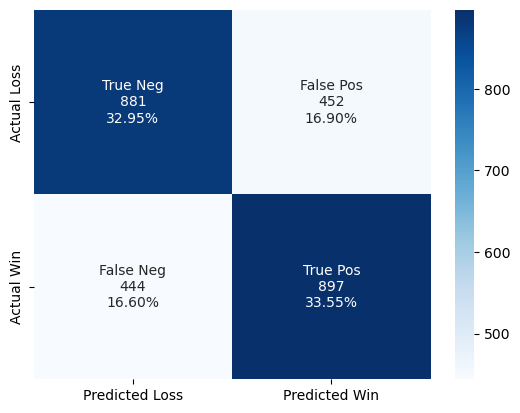

Area Under the Curve = 0.7271532648262736


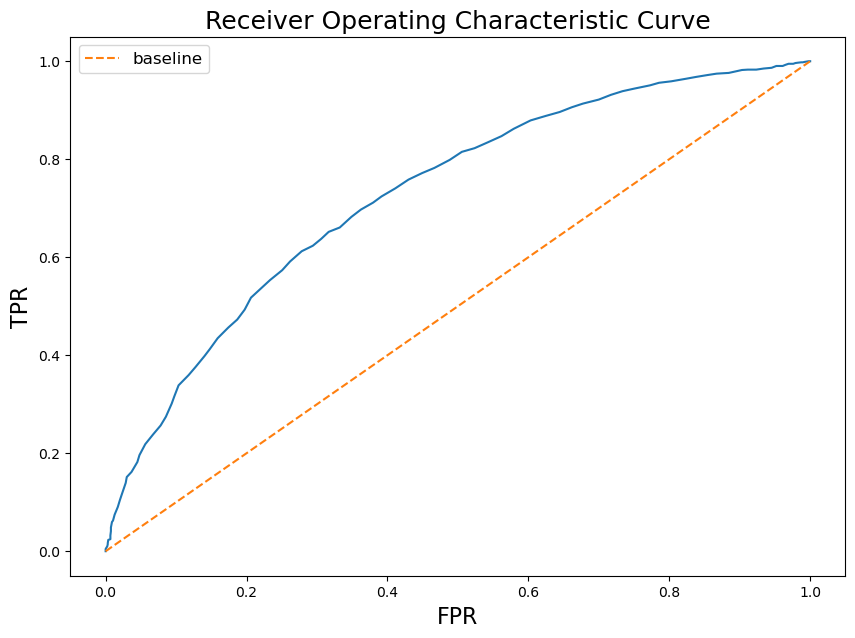

In [46]:
#evaluating reduced features model
evaluate_classification(logreg_rfe, X_val_full_rfe, y_val, extra = True)

In [88]:
#comparing the RFCVE model to the PCA model
compare_classification(hyp_logreg, logreg_rfe, X_val_full, X_val_full_rfe, y_val)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.680628272251309     0.6649214659685864     -0.015706806282722585      Accuracy: Model 1 better
AUC:  0.7343043814644936     0.7271532648262736     -0.00715111663821999      AUC: Model 1 better


## The optimized logistic regression using elasticnet with the full variable set performs better
## Lets also try optimizing the RFE model

In [48]:
space = {
    'penalty': hp.choice('penalty', ['elasticnet']),
    'solver': hp.choice('solver', ['saga']),
    'C': hp.uniform('C', 0.0,0.1),
    'l1_ratio': hp.uniform('l1_ratio', 0.0 ,1),
    'max_iter': 5000,
    'random_state': 0,
}


In [49]:
best = 0
count = 0
def f(params):
    global best, count
    count += 1
    
    model = LogisticRegression(**params)
    model.fit(X_train_full_rfe, y_train)
    
    y_pred_train = model.predict(X_train_full_rfe)
    y_pred_val = model.predict(X_val_full_rfe)
    
    acc = accuracy_score(y_val, y_pred_val)
    
    if acc > best:
        best = acc
        print('new best:', best, params, count)
        
    return {'loss': -acc,
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'train_loss': -accuracy_score(y_train, y_pred_train)}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=1000, trials=trials,
            rstate = np.random.default_rng(0))
print('best:')
print(best)

new best:                                                                       
0.6671652954375468                                                              
{'C': 0.018933342815492693, 'l1_ratio': 0.6822636207462247, 'max_iter': 5000, 'penalty': 'elasticnet', 'random_state': 0, 'solver': 'saga'}
1                                                                               
new best:                                                                       
0.6675392670157068                                                              
{'C': 0.06227743727088031, 'l1_ratio': 0.9983513763315744, 'max_iter': 5000, 'penalty': 'elasticnet', 'random_state': 0, 'solver': 'saga'}
6                                                                               
new best:                                                                       
0.6694091249065071                                                              
{'C': 0.0033826409849052053, 'l1_ratio': 0.15953324416396486, 'max_iter':

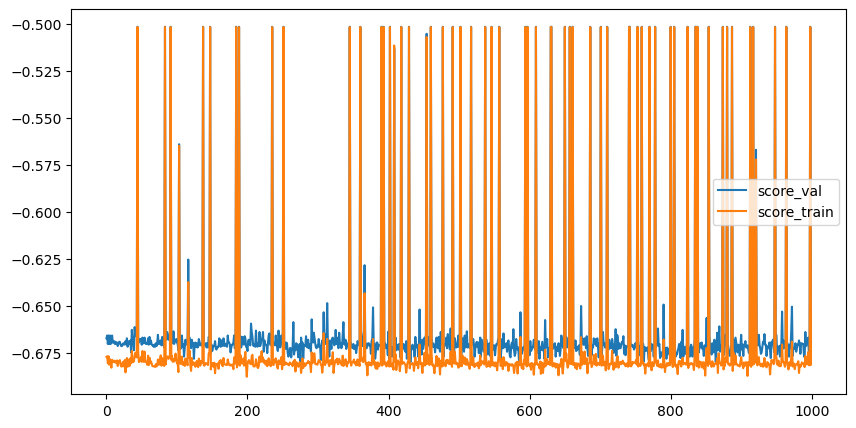

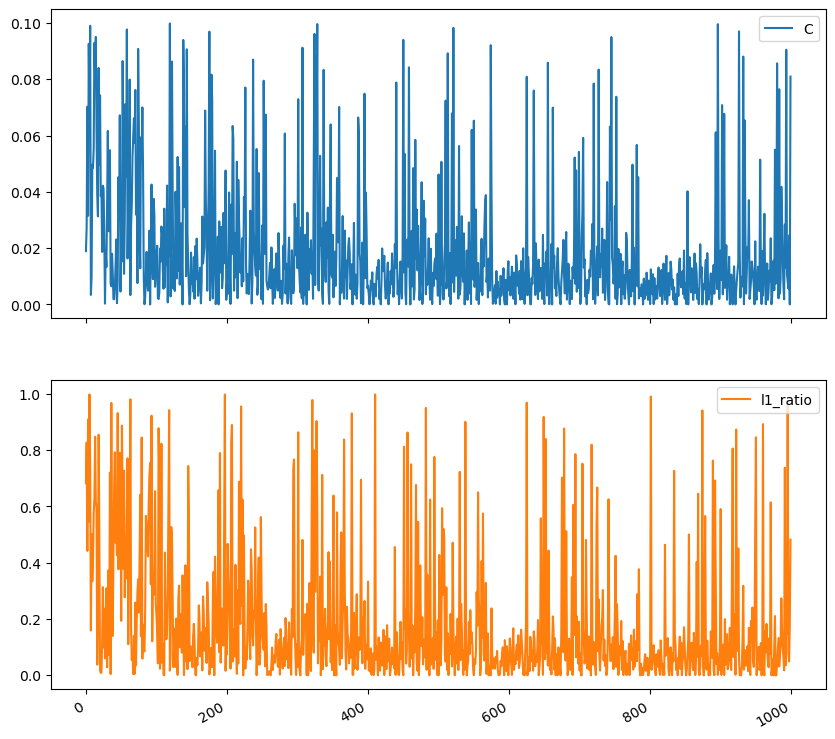

In [89]:
#examine loss and C parameter graphs over all iterations of hyperopt
results=np.array([[x['result']['loss']] for x in trials.trials])

results2=np.array([x['train_loss'] for x in trials.results])

results_loss=pd.DataFrame(results,
                           columns=['score_val'])

results_loss['score_train'] = results2

results_loss.plot(subplots=False,figsize=(10, 5))



results3=np.array([[x['misc']['vals']['C'][0],
                   x['misc']['vals']['l1_ratio'][0]] for x in trials.trials])

results_df1=pd.DataFrame(results3,
                           columns=['C', 'l1_ratio'])

results_df1.plot(subplots=True,figsize=(10, 10))


plt.show()


In [51]:
#examine best parameters
best2 = space_eval(space, best)
best2

{'C': 0.002761780703257242,
 'l1_ratio': 0.001409602358917598,
 'max_iter': 5000,
 'penalty': 'elasticnet',
 'random_state': 0,
 'solver': 'saga'}

In [52]:
#train model using best parameters
hyp_rfe = LogisticRegression(C = best2['C'],
                             l1_ratio = best2['l1_ratio'],
                             max_iter = best2['max_iter'],
                             penalty = best2['penalty'],
                             solver = best2['solver'],
                             random_state =  best2['random_state'])

hyp_rfe.fit(X_train_full_rfe, y_train)

LogisticRegression(C=0.002761780703257242, l1_ratio=0.001409602358917598,
                   max_iter=5000, penalty='elasticnet', random_state=0,
                   solver='saga')

In [53]:
y_pred = hyp_rfe.predict(X_train_full_rfe)
print('Training Data Classification Report for estimator: ',
      str(hyp_rfe).split('(')[0])
print('\n', classification_report(y_train, y_pred))

Training Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.69      0.68      3197
           1       0.69      0.69      0.69      3218

    accuracy                           0.69      6415
   macro avg       0.69      0.69      0.69      6415
weighted avg       0.69      0.69      0.69      6415



In [54]:
y_pred = hyp_rfe.predict(X_val_full_rfe)

# TEST -- classification report and store predictions/ probabilities
print('Test Data Classification Report for estimator: ',
      str(hyp_rfe).split('(')[0])
print('\n', classification_report(y_val, y_pred))

Test Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.67      0.68      1333
           1       0.68      0.68      0.68      1341

    accuracy                           0.68      2674
   macro avg       0.68      0.68      0.68      2674
weighted avg       0.68      0.68      0.68      2674



Model Performance

Accuracy =  0.6787584143605087 

Classification Report

              precision    recall  f1-score   support

           0     0.6790    0.6744    0.6767      1333
           1     0.6785    0.6831    0.6808      1341

    accuracy                         0.6788      2674
   macro avg     0.6788    0.6787    0.6787      2674
weighted avg     0.6788    0.6788    0.6788      2674



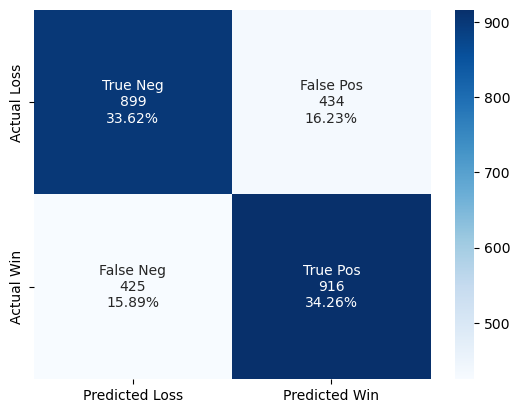

In [55]:
evaluate_classification(hyp_rfe, X_val_full_rfe, y_val)

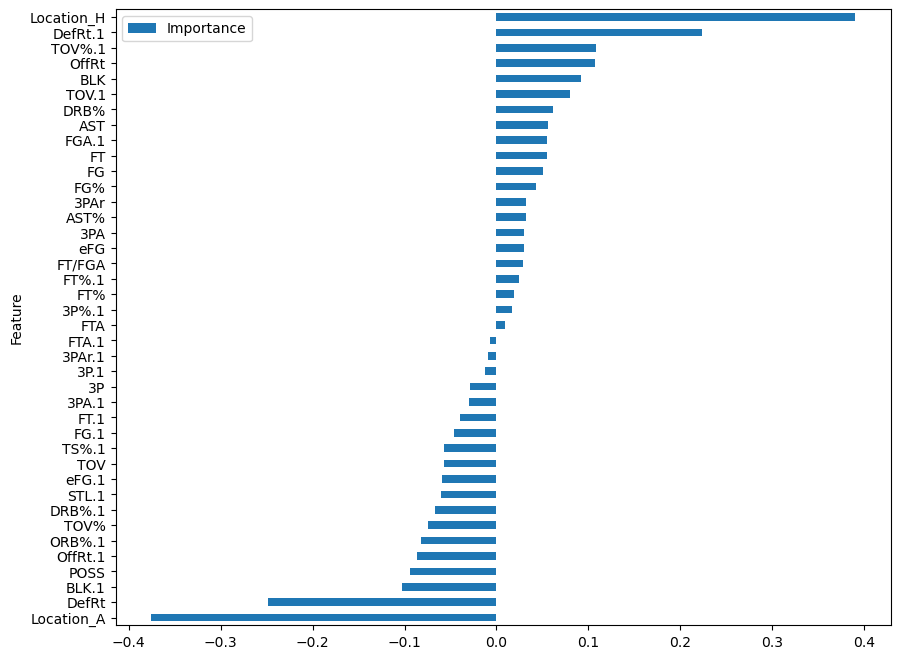

In [56]:
#examining variable importance
coefficients = hyp_rfe.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train_full_rfe.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()

In [57]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
38  Location_A   -0.376154
18       DefRt   -0.248603
28       BLK.1   -0.102297
16        POSS   -0.093556
36     OffRt.1   -0.086132
32      ORB%.1   -0.082090
11        TOV%   -0.074467
33      DRB%.1   -0.066801
27       STL.1   -0.060323
30       eFG.1   -0.059505
9          TOV   -0.056907
34       TS%.1   -0.056561
19        FG.1   -0.046596
24        FT.1   -0.039922
22       3PA.1   -0.030296
2           3P   -0.028521
21        3P.1   -0.012078
35      3PAr.1   -0.008595
25       FTA.1   -0.007379
5          FTA    0.008893
23       3P%.1    0.017260
6          FT%    0.019625
26       FT%.1    0.025081
12      FT/FGA    0.028768
10         eFG    0.029693
3          3PA    0.030347
14        AST%    0.031752
15        3PAr    0.032703
1          FG%    0.043307
0           FG    0.051229
4           FT    0.054594
20       FGA.1    0.054706
7          AST    0.056044
13        DRB%    0.061899
29       TOV.1    0.079850
8          BLK    0.092107
1

In [90]:
#comparing the RFCVE model to the PCA model
compare_classification(hyp_logreg, hyp_rfe, X_val_full, X_val_full_rfe, y_val)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.680628272251309     0.6787584143605087     -0.0018698578908002972      Accuracy: Model 1 better
AUC:  0.7343043814644936     0.7308767907860635     -0.0034275906784301258      AUC: Model 1 better


## The optimized logistic regression model using elasticnet still performs best.

## We have seen from the results of the elasticnet that not all variables are considered important to the model. We tried using RFE to reduce the variable space, but lets try a more hands on approach. First we should examine if there are high correlations between any continuous variables by first visually inspecting a correlation plot.

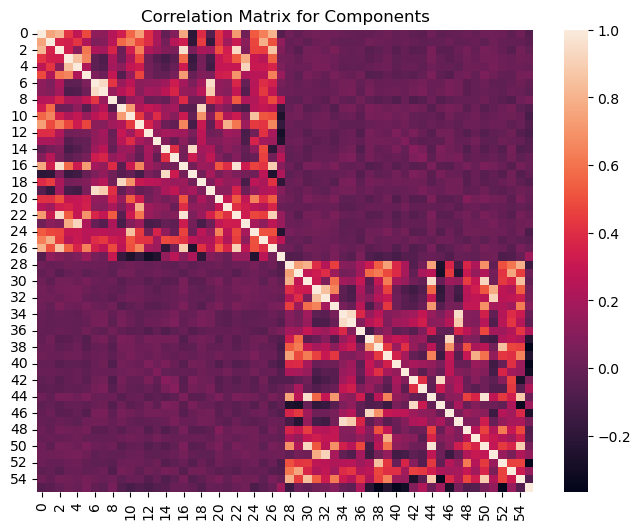

In [59]:
#examining the correlations between the standardized continuous variables
fig, ax = plt.subplots(figsize=(8,6))
corr_mat = np.corrcoef(X_train_std.transpose())
sns.heatmap(corr_mat)
ax.set(title = 'Correlation Matrix for Components')
plt.show()

## We see that the variables from team 1 have low to no correlation with team 2, however we also see that some of the variables within a team have high correlations. Lets explore that further.

In [60]:
#create a dataframe of correlations
corr_frame = pd.DataFrame()


for i in X_train_std.columns:
    for j in X_train_std.columns:
        value = X_train_std[i].corr(X_train_std[j])
        df2 = {'Var1': i, 'Correlation': value, 'Var2': j}
        corr_frame = corr_frame.append(df2, ignore_index = True)

corr_frame = corr_frame.reset_index(drop = True)
#filter correlations above 0.7
pd.options.display.max_rows = 70
corr_frame = corr_frame[(corr_frame['Correlation'] < 0.99) & (corr_frame['Correlation'] > 0.7)]
display(corr_frame)
pd.options.display.max_rows = 10

,Correlation,Var1,Var2
1,0.750800,FG,FGA
2,0.810116,FG,FG%
11,0.730237,FG,AST
16,0.767375,FG,eFG
22,0.713083,FG,TS%
...,...,...,...
2997,0.759284,POSS.1,FGA.1
3052,0.787904,OffRt.1,FG.1
3054,0.840411,OffRt.1,FG%.1
3068,0.872358,OffRt.1,eFG.1


## Many of the high correlations have to do with a variable and its % version, lets look at the VIF values to help

In [61]:
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = X_train_std.columns 
 
    
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(X_train_std.values, i) for i in range(len(X_train_std.columns))] 

pd.options.display.max_rows = 70
display(vif_scores)
pd.options.display.max_rows = 10

/Users/piercecappelli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Attribute,VIF Scores
0,FG,157.122001
1,FGA,inf
2,FG%,2976.402139
3,3P,329.657213
4,3PA,344.779005
5,3P%,17.000457
6,FT,180.905004
7,FTA,inf
8,FT%,9.897294
9,ORB,inf


## Many variables have extremely high VIF scores, lets remove several and see how it improves our model. We can also remember that our variable importance chart previous indicated that many of our variables were not that important

In [62]:
#standardize continuous variables
scaler = preprocessing.StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train1))
X_train_std.columns = X_train1.columns
X_val_std = pd.DataFrame(scaler.transform(X_val1))
X_val_std.columns = X_val1.columns
X_test_std = pd.DataFrame(scaler.transform(X_test1))
X_test_std.columns = X_test1.columns

#remove certain variables with high VIF factors
X_train_sub = X_train_std.drop(columns = ['FG%','FG%.1', 'FGA', 'FGA.1', 'FTA', 'FTA.1', 'TRB', 'TRB.1', '3PA', '3PA.1',
                           'FG', 'FG.1', 'FT%', 'FT%.1', '3P%', '3P%.1', '3P', '3P.1', 'TOV', 'TOV.1',
                            'FT', 'FT.1',
                            'TS%', 'TS%.1', 'eFG', 'eFG.1','ORB','ORB.1','DRB', 'DRB.1', 'AST', 'AST.1'])

X_val_sub = X_val_std.drop(columns = ['FG%','FG%.1', 'FGA', 'FGA.1', 'FTA', 'FTA.1', 'TRB', 'TRB.1', '3PA', '3PA.1',
                           'FG', 'FG.1', 'FT%', 'FT%.1', '3P%', '3P%.1', '3P', '3P.1', 'TOV', 'TOV.1',
                           'FT', 'FT.1',
                           'TS%', 'TS%.1', 'eFG', 'eFG.1','ORB','ORB.1','DRB', 'DRB.1', 'AST', 'AST.1'])

X_test_sub = X_test_std.drop(columns = ['FG%','FG%.1', 'FGA', 'FGA.1', 'FTA', 'FTA.1', 'TRB', 'TRB.1', '3PA', '3PA.1',
                           'FG', 'FG.1', 'FT%', 'FT%.1', '3P%', '3P%.1', '3P', '3P.1', 'TOV', 'TOV.1',
                           'FT', 'FT.1',
                           'TS%', 'TS%.1', 'eFG', 'eFG.1','ORB','ORB.1','DRB', 'DRB.1', 'AST', 'AST.1'])

#combine continuous and categorical variables
X_train_sub_d = pd.concat([X_train_sub, dummy_train], axis = 1)
X_val_sub_d = pd.concat([X_val_sub, dummy_val], axis = 1)
X_test_sub_d = pd.concat([X_test_sub, dummy_test], axis = 1)

#drop on category for logistic regression modelling
X_train_full_sub = X_train_sub_d.drop(['Location_N'], axis = 1)
X_val_full_sub = X_val_sub_d.drop(['Location_N'], axis = 1)
X_test_full_sub = X_test_sub_d.drop(['Location_N'], axis = 1)

## Reinspect the VIF values

In [63]:
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = X_train_full_sub.columns 
 
    
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(X_train_full_sub.values, i) for i in range(len(X_train_full_sub.columns))] 

pd.options.display.max_rows = 70
display(vif_scores)
pd.options.display.max_rows = 10

,Attribute,VIF Scores
0,STL,1.715770
1,BLK,1.231980
2,PF,1.536697
3,TOV%,1.643367
4,ORB%,1.545432
5,FT/FGA,1.297366
6,DRB%,1.709964
7,AST%,1.356740
8,3PAr,1.333849
9,POSS,2.377327


## VIF scores look great, lets try modelling with this reduced set of variables

In [64]:
logreg_sub = LogisticRegression(max_iter = 5000, random_state = 0)

logreg_sub.fit(X_train_full_sub, y_train)

LogisticRegression(max_iter=5000, random_state=0)

Model Performance

Accuracy =  0.6705310396409873 

Classification Report

              precision    recall  f1-score   support

           0     0.6728    0.6602    0.6664      1333
           1     0.6684    0.6808    0.6745      1341

    accuracy                         0.6705      2674
   macro avg     0.6706    0.6705    0.6705      2674
weighted avg     0.6706    0.6705    0.6705      2674



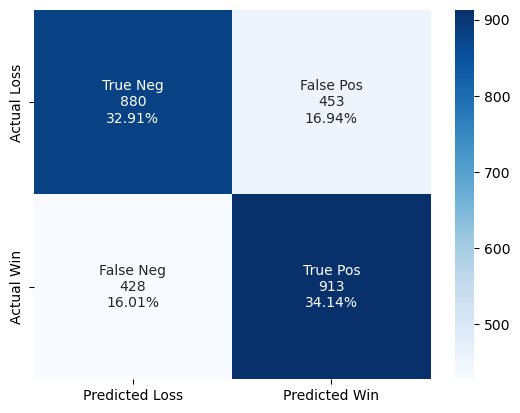

In [65]:
evaluate_classification(logreg_sub, X_val_full_sub, y_val)

In [91]:
#comparing the reduced variable model to the optimized full variable model
compare_classification(hyp_logreg, logreg_sub, X_val_full, X_val_full_sub, y_val)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.680628272251309     0.6705310396409873     -0.010097232610321694      Accuracy: Model 1 better
AUC:  0.7343043814644936     0.7318647335211879     -0.002439647943305756      AUC: Model 1 better


## The optimized model with full data still performs best on accuracy, lets try optimizing the reduced variable model

In [67]:
space = {
    'penalty': hp.choice('penalty', ['elasticnet']),
    'solver': hp.choice('solver', ['saga']),
    'C': hp.uniform('C', 0.0, 0.1),
    'l1_ratio': hp.uniform('l1_ratio', 0,1),
    'max_iter': 5000,
    'random_state': 0,
}


In [68]:
best = 0
count = 0
def f(params):
    global best, count
    count += 1
    
    model = LogisticRegression(**params)
    model.fit(X_train_full_sub, y_train)
    
    y_pred_train = model.predict(X_train_full_sub)
    y_pred_val = model.predict(X_val_full_sub)
    
    acc = accuracy_score(y_val, y_pred_val)
    
    if acc > best:
        best = acc
        print('new best:', best, params, count)
        
    return {'loss': -acc,
            'status': STATUS_OK,
            'model': model,
            'params': params,
            'train_loss': -accuracy_score(y_train, y_pred_train)}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=1000, trials=trials,
            rstate = np.random.default_rng(0))
print('best:')
print(best)

new best:                                                                       
0.6671652954375468                                                              
{'C': 0.018933342815492693, 'l1_ratio': 0.6822636207462247, 'max_iter': 5000, 'penalty': 'elasticnet', 'random_state': 0, 'solver': 'saga'}
1                                                                               
new best:                                                                       
0.6701570680628273                                                              
{'C': 0.07028021307836788, 'l1_ratio': 0.4421542674710245, 'max_iter': 5000, 'penalty': 'elasticnet', 'random_state': 0, 'solver': 'saga'}
3                                                                               
new best:                                                                       
0.6712789827973074                                                              
{'C': 0.03918159993436591, 'l1_ratio': 0.03799065060696949, 'max_iter': 5

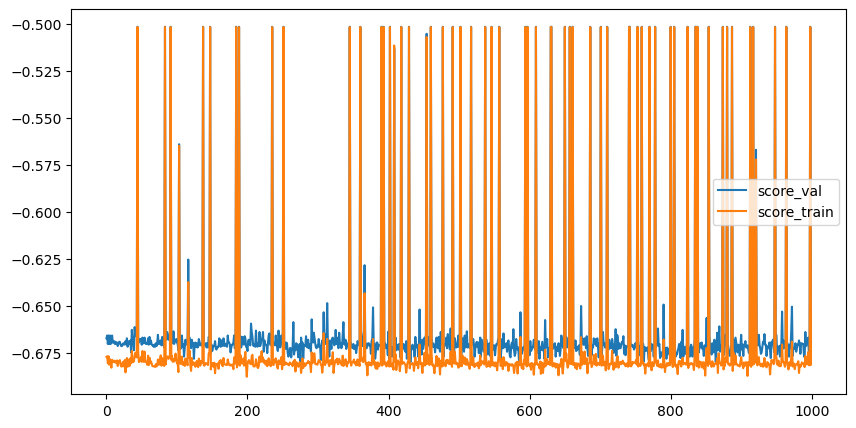

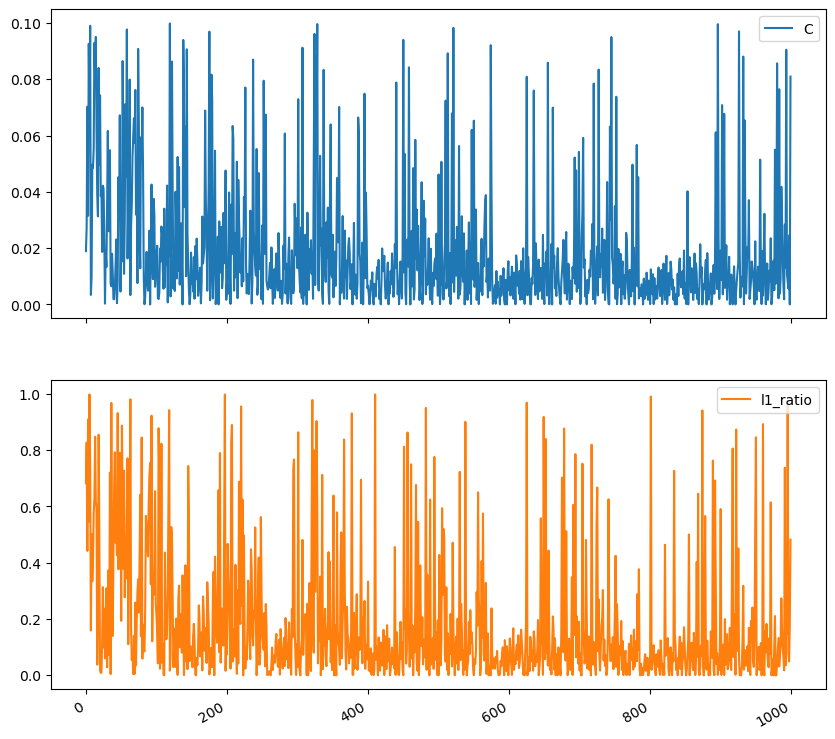

In [92]:
#examine loss and C parameter graphs over all iterations of hyperopt
results=np.array([[x['result']['loss']] for x in trials.trials])

results2=np.array([x['train_loss'] for x in trials.results])

results_loss=pd.DataFrame(results,
                           columns=['score_val'])

results_loss['score_train'] = results2

results_loss.plot(subplots=False,figsize=(10, 5))



results3=np.array([[x['misc']['vals']['C'][0],
                   x['misc']['vals']['l1_ratio'][0]] for x in trials.trials])

results_df1=pd.DataFrame(results3,
                           columns=['C', 'l1_ratio'])

results_df1.plot(subplots=True,figsize=(10, 10))


plt.show()


In [70]:
#examine best parameters
best3 = space_eval(space, best)
best3

{'C': 0.004005232731935515,
 'l1_ratio': 0.0003522511591517283,
 'max_iter': 5000,
 'penalty': 'elasticnet',
 'random_state': 0,
 'solver': 'saga'}

In [71]:
#train model using best parameters
hyp_sub = LogisticRegression(C = best3['C'],
                             l1_ratio = best3['l1_ratio'],
                  max_iter = best3['max_iter'],
                  penalty = best3['penalty'],
                  solver = best3['solver'],
                  random_state =  best3['random_state'])

hyp_sub.fit(X_train_full_sub, y_train)

LogisticRegression(C=0.004005232731935515, l1_ratio=0.0003522511591517283,
                   max_iter=5000, penalty='elasticnet', random_state=0,
                   solver='saga')

In [72]:
y_pred = hyp_sub.predict(X_train_full_sub)
print('Training Data Classification Report for estimator: ',
      str(hyp_rfe).split('(')[0])
print('\n', classification_report(y_train, y_pred))


Training Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.68      0.68      3197
           1       0.68      0.68      0.68      3218

    accuracy                           0.68      6415
   macro avg       0.68      0.68      0.68      6415
weighted avg       0.68      0.68      0.68      6415



In [73]:
y_pred = hyp_sub.predict(X_val_full_sub)

# TEST -- classification report and store predictions/ probabilities
print('Test Data Classification Report for estimator: ',
      str(hyp_sub).split('(')[0])
print('\n', classification_report(y_val, y_pred))


Test Data Classification Report for estimator:  LogisticRegression

               precision    recall  f1-score   support

           0       0.68      0.68      0.68      1333
           1       0.68      0.68      0.68      1341

    accuracy                           0.68      2674
   macro avg       0.68      0.68      0.68      2674
weighted avg       0.68      0.68      0.68      2674



Model Performance

Accuracy =  0.6798803290949887 

Classification Report

              precision    recall  f1-score   support

           0     0.6803    0.6752    0.6777      1333
           1     0.6795    0.6846    0.6820      1341

    accuracy                         0.6799      2674
   macro avg     0.6799    0.6799    0.6799      2674
weighted avg     0.6799    0.6799    0.6799      2674



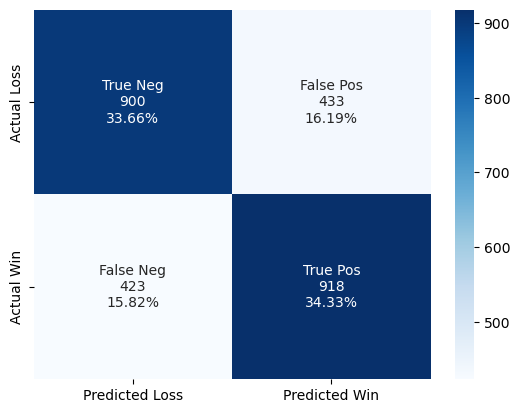

In [74]:
evaluate_classification(hyp_sub, X_val_full_sub, y_val)

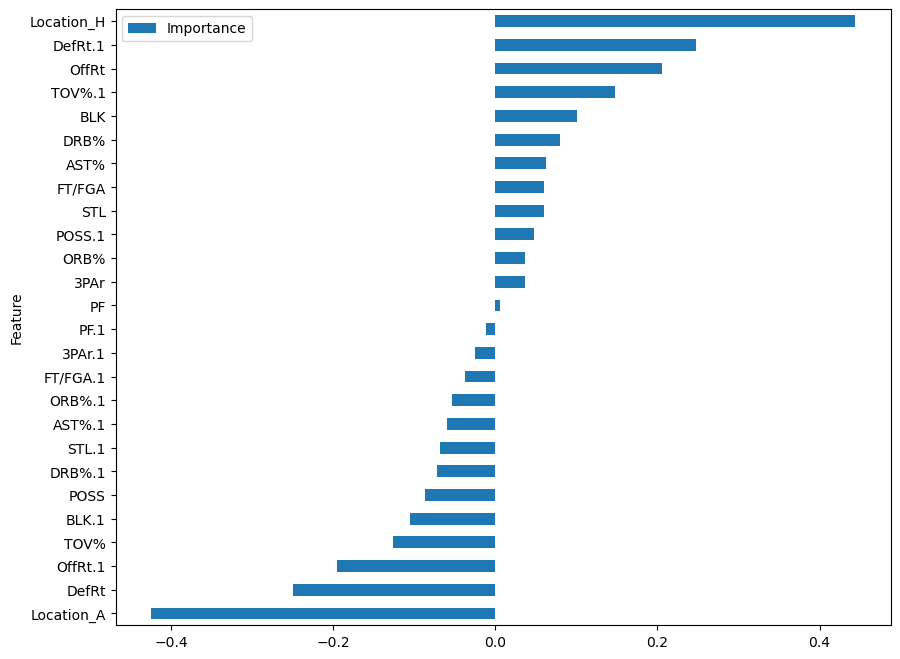

In [75]:
#examining variable importance
coefficients = hyp_sub.coef_[0]
feature_importance = pd.DataFrame({'Feature': X_train_full_sub.columns, 'Importance':coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 8))
plt.show()


In [76]:
pd.options.display.max_rows = 70
print(feature_importance)
pd.options.display.max_rows = 10

       Feature  Importance
24  Location_A   -0.424870
11       DefRt   -0.249428
22     OffRt.1   -0.195132
3         TOV%   -0.126399
13       BLK.1   -0.104875
9         POSS   -0.087197
18      DRB%.1   -0.072365
12       STL.1   -0.068236
19      AST%.1   -0.060021
16      ORB%.1   -0.053664
17    FT/FGA.1   -0.037354
20      3PAr.1   -0.024866
14        PF.1   -0.011495
2           PF    0.006285
8         3PAr    0.036824
4         ORB%    0.037094
21      POSS.1    0.047316
0          STL    0.059551
5       FT/FGA    0.060344
7         AST%    0.062922
6         DRB%    0.080367
1          BLK    0.100272
15      TOV%.1    0.148194
10       OffRt    0.205537
23     DefRt.1    0.248058
25  Location_H    0.444112


In [95]:
#comparing the optimized reduced variable model to the optimized full variable model
compare_classification(hyp_logreg, hyp_sub, X_val_full, X_val_full_sub, y_val)

           Model 1 Performance    Model 2 Performance   Difference (Model2 - Model1)
Accuracy:  0.680628272251309     0.6798803290949887     -0.0007479431563202077      Accuracy: Model 1 better
AUC:  0.7343043814644936     0.7322071009922503     -0.0020972804722433347      AUC: Model 1 better


## The optimized full variable model still performs the best.

## Now that we have all of our models optimized, we can finally evaluate how they perform on the test data

In [96]:
mods = [logreg,
        hyp_logreg,
        logreg_rfe,
        hyp_rfe,
        logreg_sub,
        hyp_sub]

feats = [X_test_full,
         X_test_full,
         X_test_full_rfe,
         X_test_full_rfe,
         X_test_full_sub,
         X_test_full_sub]

outcomes = y_test

test_evaluation = evaluate_test(mods, feats, outcomes)

In [97]:
test_evaluation

,model_name,model,data_name,data,acc,auc,acc_rank,auc_rank
3,hyp_rfe,"LogisticRegression(C=0.002761780703257242, l1_...",X_test_full_rfe,"{'FG': {0: -1.2491285165619037, 1: -0.03838059...",0.680798,0.741882,1.0,3.0
2,logreg_rfe,"LogisticRegression(max_iter=5000, random_state=0)",X_test_full_rfe,"{'FG': {0: -1.2491285165619037, 1: -0.03838059...",0.677681,0.735974,2.0,6.0
5,hyp_sub,"LogisticRegression(C=0.004005232731935515, l1_...",X_test_full_sub,"{'STL': {0: -0.11828501075573525, 1: 0.2579685...",0.675810,0.742145,3.0,2.0
1,hyp_logreg,"LogisticRegression(C=0.0036075505610419084, l1...",X_test_full,"{'FG': {0: -1.2491285165619037, 1: -0.03838059...",0.674564,0.742896,4.5,1.0
4,logreg_sub,"LogisticRegression(max_iter=5000, random_state=0)",X_test_full_sub,"{'STL': {0: -0.11828501075573525, 1: 0.2579685...",0.674564,0.740115,4.5,4.0
0,logreg,"LogisticRegression(max_iter=1000, penalty='non...",X_test_full,"{'FG': {0: -1.2491285165619037, 1: -0.03838059...",0.673317,0.736969,6.0,5.0


In [80]:
best_index = test_evaluation.index.values.astype(int)[0]
best_model = test_evaluation['model'].loc[best_index]
best_params = test_evaluation['model'].loc[best_index].get_params()
best_data = pd.DataFrame(test_evaluation['data'].loc[best_index])

In [81]:
best_model

LogisticRegression(C=0.002761780703257242, l1_ratio=0.001409602358917598,
                   max_iter=5000, penalty='elasticnet', random_state=0,
                   solver='saga')

# Conclusion

## After exploring the variable relationships and variable importance graphs, it appears there playing location and offensive and defense rating are the most valuable features. This makes sense when you consider 'home court advantage' as well as the fact that offensive and defense rating take into account a multitude of both offensive and defense statistics. The reduced variable optimized model performed best on the test data

## Next notebook will explore using a Gradient boosting model